#Pecan model & ground truth data analysis

Here we perform analysis on the model vs ground truth data for thermal and occupancy consumption. We contrast two models:
* ground truth thermal response: a locally-weighted regression model using separately-monitored HVAC and temperature
* the HMM thermal model

##Initializations

In [106]:
rm(list = ls())

In [107]:
options(error = recover)
library('segmented')
library('lubridate')
library('ggplot2')
library(zoo)
library('reshape2')
library('PerformanceAnalytics')
library('RColorBrewer')
library('pracma')
library('fields')

In [108]:
setwd("~/EnergyAnalytics/thermal_profiles/")
source("validator/drank.r")

In [109]:
DATA_PATH = '~/S3L_server/energy-data/pecan_street/usage-select/'
PLOT_PATH = '~/S3L_server/plots/pecan-street-2/'
MODEL_PATH= '~/S3L_server/energy-data/pecan_street/models_2/'

In [110]:
dir.create(PLOT_PATH, recursive = T)

Warning message:
In dir.create(PLOT_PATH, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2' already exists

Paths to original data

In [111]:
# load user names
user_names = read.csv('~/S3L_server/energy-data/pecan_street/metadata/user_names_ids.csv')
user_names$X = NULL

# list all data files
files    = list.files(path=DATA_PATH, full.names = T, recursive = T)
# files_01 = files[grep('01min',files)]
# files_15 = files[grep('15min',files)]
files_60 = files[grep('60min',files)]

# extract ID
users_df = data.frame(UID = as.character(sapply(files_60, function(s) strsplit(tail(strsplit(s, '/')[[1]], 1), '\\.')[[1]][1])))
rownames(users_df) = NULL
    
# build original data sources dataframe
users_df = merge(users_df, user_names, by.x="UID", by.y="ID")
# users_df['01min'] = files_01
# users_df['15min'] = files_15
users_df['60min'] = files_60
users_df = melt(users_df, id=c("UID","name"))
names(users_df)[c(3,4)] = c("grain", "file_orig")  
print(paste("There are", nrow(users_df), "original data files"))

[1] "There are 349 original data files"


In [112]:
users_df[1,]

,UID,name,grain,file_orig
1,1069,Edd,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/1069.csv


Paths to thermal models data

In [113]:
# models 
files_dec = list.files(path=MODEL_PATH, pattern="*decoded", full.names = T, recursive = T)
files_int = list.files(path=MODEL_PATH, pattern="*interpreted", full.names = T, recursive = T)
f_dum = function(x) {
    tmp = tail(strsplit(x, '/')[[1]],n=2)
    res = tmp[1]
    nfo = strsplit(tmp[2], "_")[[1]]
    uid = nfo[1]; name = nfo[2]; 
    return(c(uid,name,res,x))
}
model_paths_dec = data.frame(do.call('rbind', lapply(files_dec, f_dum)))
model_paths_int = data.frame(do.call('rbind', lapply(files_int, f_dum)))

if (length(model_paths_dec)>0) names(model_paths_dec) <- c("UID", "name", "grain", "file_model")
if (length(model_paths_int)>0) names(model_paths_int) <- c("UID", "name", "grain", "file_model")
model_paths = merge(model_paths_dec, model_paths_int, by=c("UID", "name", "grain"), suffixes=c("_decode", "_interp"))

In [114]:
info_files = merge(model_paths, users_df, by=c("UID", "name", "grain"))
info_files = info_files[with(info_files, order(UID,grain,name)),]
print(paste("There are", nrow(info_files), "files"))

[1] "There are 301 files"


In [115]:
info_files[1:2,]

,UID,name,grain,file_model_decode,file_model_interp,file_orig
1,1069,Edd,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//1069_Edd/60min/1069_Edd_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//1069_Edd/60min/1069_Edd_interpreted.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/1069.csv
2,1086,Emery,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//1086_Emery/60min/1086_Emery_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//1086_Emery/60min/1086_Emery_interpreted.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/1086.csv


##Load processed thermal regimes data

In [116]:
f_process_model = function(row) {
    # access decoded data    
    load(as.character(as.character(row$file_model_decode)));
    df = data$df
    nStates= data$nStates
    df     = cbind(df, data$state)
    df$TemperatureD = df$Temperature - 65
    resp   = data$response   
    tran   = data$transition
    tran   = lapply(unique(tran$From), function(s) {d = subset(tran, To ==s); d$From = d$To = NULL; rownames(d) = 1:nrow(d); return(d)})

    # format model parameters for easy analysis access
    volatility = lapply(1:nStates, function(s) { z = c(mu = 0, sd = resp$stdev[s]); names(z) = c('mu', 'sd'); z})
    baseload   = lapply(1:nStates, function(s) { z = c(mu = resp$means['(Intercept)', s], sd = resp$stderr['(Intercept)', s]); names(z) = c('mu', 'sd'); z})
    response   = lapply(1:nStates, function(s) c(mu = resp$means['TemperatureD', s], sd = as.numeric(resp$stderr['TemperatureD', s])))
    
    df$resp_MAP   = sapply(df$state, function(s) response[[s]]['mu'])
    df$resp_MAP.se= sapply(df$state, function(s) response[[s]]['sd'])
    tmp = df[grepl("X[1-9]", names(df))] * matrix(unlist(response), nrow=2)
    df$resp_avg   = rowSums(tmp[1,])
    df$resp_avg.se= apply(tmp[1,], 1, sd)
        
    # access "interpreted" quantities
    load(as.character(as.character(row$file_model_interp)));
    response_df = data.frame(matrix(unlist(response), nrow=2))
    names(response_df) = as.character(1:nStates)
    rownames(response_df) = c("mu", "sd")
    res = data$benchmarks$steadyDistr %*% as.matrix(t(response_df))
    resp = data.frame(Temperature = 1:nrow(res), 
                      resp_avg=res[,1], resp_avg.se=res[,2],
                      resp_MAP=apply(data$benchmarks$steadyDistr, 1, function(r) response[[which.max(r)]]['mu']),
                      resp_MAP.se=apply(data$benchmarks$steadyDistr, 1, function(r) response[[which.max(r)]]['sd']))
    prob_steady = data.frame(data$benchmarks$steadyDistr)
    names(prob_steady) = paste("X", 1:nStates, sep='')
    resp = cbind(resp, prob_steady)

    res = list(volatility = volatility, 
               baseload = baseload, 
               response = response, 
               tran = tran, 
               nStates = nStates,
               resp_profile = resp,
               data = df)
    gc()
    return(res)
}

In [117]:
row = info_files[3,]
res = f_process_model(row)
head(res$data)

,obs,TemperatureD,Temperature,timestamps,state,X1,X2,X3,fit,fit.max,resp_MAP,resp_MAP.se,resp_avg,resp_avg.se
1,0.4943333,-9.641,55.359,2013-11-13 16:00:00,1,0.9916136,0.008386358,0,0.8531127,0.8580622,-0.007384663,0.001090608,-0.007384663,0.004210018
2,0.4058167,-12.65167,52.34833,2013-11-13 17:00:00,1,0.3525087,0.6474913,6.271976e-105,0.4857133,0.880295,-0.007384663,0.001090608,-0.007384663,0.004210018
3,0.94945,-17.34,47.66,2013-11-13 18:00:00,1,0.999997,2.952674e-06,0,0.9149148,0.9149167,-0.007384663,0.001090608,-0.007384663,0.004210018
4,0.4052833,-21.231,43.769,2013-11-13 19:00:00,2,0.3355777,0.6644223,9.702375e-105,0.5023781,0.2795061,-0.001003792,0.0002524065,-0.007384663,0.004210018
5,0.31975,-23.89367,41.10633,2013-11-13 20:00:00,2,0.04045171,0.9595483,6.937335e-55,0.3097319,0.2821788,-0.001003792,0.0002524065,-0.007384663,0.004210018
6,0.1960833,-26.196,38.804,2013-11-13 21:00:00,2,0.004835956,0.995164,3.92608e-11,0.2878549,0.2844899,-0.001003792,0.0002524065,-0.007384663,0.004210018


In [118]:
row

,UID,name,grain,file_model_decode,file_model_interp,file_orig
3,1105,Grant,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//1105_Grant/60min/1105_Grant_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//1105_Grant/60min/1105_Grant_interpreted.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/1105.csv


In [119]:
table(res$data$state)


   1    2    3 
 443 1214 1247 

In [120]:
str(res)

List of 7
 $ volatility  :List of 3
  ..$ : Named num [1:2] 0 0.388
  .. ..- attr(*, "names")= chr [1:2] "mu" "sd"
  ..$ : Named num [1:2] 0 0.125
  .. ..- attr(*, "names")= chr [1:2] "mu" "sd"
  ..$ : Named num [1:2] 0 0.0141
  .. ..- attr(*, "names")= chr [1:2] "mu" "sd"
 $ baseload    :List of 3
  ..$ : Named num [1:2] 0.7869 0.0238
  .. ..- attr(*, "names")= chr [1:2] "mu" "sd"
  ..$ : Named num [1:2] 0.25819 0.00463
  .. ..- attr(*, "names")= chr [1:2] "mu" "sd"
  ..$ : Named num [1:2] 0.096772 0.000571
  .. ..- attr(*, "names")= chr [1:2] "mu" "sd"
 $ response    :List of 3
  ..$ : Named num [1:2] -0.00738 0.00109
  .. ..- attr(*, "names")= chr [1:2] "mu" "sd"
  ..$ : Named num [1:2] -0.001004 0.000252
  .. ..- attr(*, "names")= chr [1:2] "mu" "sd"
  ..$ : Named num [1:2] 3.97e-05 2.86e-05
  .. ..- attr(*, "names")= chr [1:2] "mu" "sd"
 $ tran        :List of 3
  ..$ :'data.frame':	3 obs. of  2 variables:
  .. ..$ (Intercept): num [1:3] 0 0 0
  .. ..$ Temperature: num [1:3] 0 0 0

In [121]:
f_estimate_empirical_prob = function(temp_df){
    temp_df = temp_df[,c("Temperature", "state")]
    temp_df = temp_df[with(temp_df, order(Temperature)),]
    resp_est_df = data.frame(Temperature = 1:120)
    n = length(unique(temp_df$state))
    prof_est = sapply(1:120, function(t){
        cur_df = subset(temp_df, (Temperature >= t-1) & (Temperature <= t+1))
        tmp = rep(0,n); names(tmp) = as.character(1:n)
        tab = table(cur_df$state)/nrow(cur_df)
        tmp[names(tab)] = tab
        return(t(tmp))
    })
    prof_est = t(prof_est)
    names(prof_est) = paste("X", 1:n)
    prof_est = data.frame(prof_est)
    prof_est$Temperature = 1:120
    gc()
    return(prof_est)
}

In [122]:
prof_est = f_estimate_empirical_prob(res$data)
head(prof_est)

,X1,X2,X3,Temperature
1,0,0,0,1
2,0,0,0,2
3,0,0,0,3
4,0,0,0,4
5,0,0,0,5
6,0,0,0,6


In [123]:
f_plot_prob_profiles = function(prof_est, prof_steady) {
    nStates = ncol(prof_est)-1
    # define colors
    add.alpha <- function(col, alpha=1){
      if(missing(col))
        stop("Please provide a vector of colours.")
      apply(sapply(col, col2rgb)/255, 2, 
                         function(x) 
                           rgb(x[1], x[2], x[3], alpha=alpha))  
    }
    cols <- brewer.pal(nStates,"Dark2")
    colsAlpha = add.alpha(cols, 0.3)
            
    # produce plots
    plot(prof_est$Temperature, prof_est$X1, col=colsAlpha[1], type = 'b', lwd=3, 
         cex.main=1.5, 
         cex.lab=1.5,
         cex.axis=1.5,
         ylim=c(0,1),
         main="Thermal Regime Temperature Profile", 
         xlab="Temperature [F]", ylab="P(S=j;T)")
    points(prof_steady$Temperature, prof_steady$X1, col=cols[1], type = 'l', lty=1, lwd=5)
    for (n in 2:nStates){ 
        points(prof_est$Temperature, prof_est[,paste("X",n,sep="")], col=colsAlpha[n], type = 'b', lwd=3)
        points(prof_steady$Temperature, prof_steady[,paste("X",n,sep="")], col=cols[n], type = 'l', lty=1, lwd=5)
    }

    legend("right", sprintf("P(S=%d)",1:nStates), col=cols, lty=1, lwd=4)
    gc()
}

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,711425,38,1442291,77.1,1442291,77.1
Vcells,932488,7.2,3253184,24.9,6918738,52.8


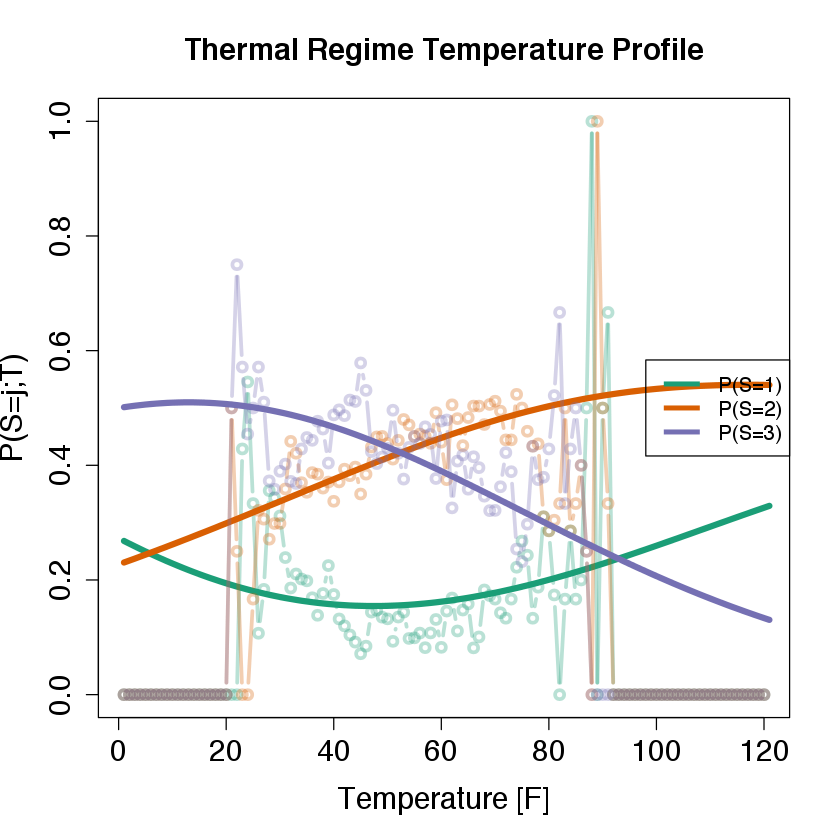

In [124]:
f_plot_prob_profiles(prof_est, res$resp_profile)

##Estimate "ground truth" thermal response

In [125]:
# format data to match the observations available for thermal modeling
f_estimate_GT_resp = function(df_orig, timestamps){
    df_orig$HVAC = 0
    if ('H' %in% names(df_orig)) df_orig$HVAC = df_orig$HVAC + df_orig$H
    if ('C' %in% names(df_orig)) df_orig$HVAC = df_orig$HVAC + df_orig$C
    df_orig$TemperatureD = df_orig$Temperature - 65
    df_orig = subset(df_orig, date %in% timestamps)
    
    temp_vec = 1:120
    df_resp = data.frame(Temperature = temp_vec)

    fit                 = lowess(df_orig$Temperature, df_orig$HVAC) 
    plx_grid            = approx(fit$x, fit$y, temp_vec)
    df_resp$fit_HVAC    = na.locf(na.locf(plx_grid$y, na.rm=FALSE), fromLast=TRUE)
    df_resp$resp_HVAC   = na.locf(na.locf(c(NA,diff(plx_grid$y)), na.rm=FALSE), fromLast=TRUE)
    #df_orig$resp_HVAC   = fit$y

    # learn "ground truth" thermal response for HV and AC
    if ('H' %in% names(df_orig))
        fit               = lowess(df_orig$Temperature, df_orig$H) 
        plx_grid          = approx(fit$x, fit$y, temp_vec)
        df_resp$fit_HV    = na.locf(na.locf(plx_grid$y, na.rm=FALSE), fromLast=TRUE)
        df_resp$resp_HV   = na.locf(na.locf(c(NA,diff(plx_grid$y)), na.rm=FALSE), fromLast=TRUE)
        #df_orig$resp_HV   = fit$y

    if ('C' %in% names(df_orig))
        fit               = lowess(df_orig$Temperature, df_orig$C) 
        plx_grid          = approx(fit$x, fit$y, temp_vec)
        df_resp$fit_AC    = na.locf(na.locf(plx_grid$y, na.rm=FALSE), fromLast=TRUE)
        df_resp$resp_AC   = na.locf(na.locf(c(NA,diff(plx_grid$y)), na.rm=FALSE), fromLast=TRUE)
        #df_orig$resp_AC   = fit$y
        
    gc()
    return(df_resp)
}
        

In [126]:
df_orig = read.csv(as.character(row$file_orig))
df_resp = f_estimate_GT_resp(df_orig, res$data$timestamps)
head(df_resp)

,Temperature,fit_HVAC,resp_HVAC,fit_HV,resp_HV,fit_AC,resp_AC
1,1,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05
2,2,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05
3,3,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05
4,4,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05
5,5,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05
6,6,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05


## Estimate "breakpoint" linear model 

In [127]:
row

,UID,name,grain,file_model_decode,file_model_interp,file_orig
3,1105,Grant,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//1105_Grant/60min/1105_Grant_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//1105_Grant/60min/1105_Grant_interpreted.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/1105.csv


In [128]:
df_orig = read.csv(as.character(row$file_orig))
head(df_orig)

,date,total,C,user,Temperature
1,2013-11-13 16:00:00,0.4943333,0.00295,0.4913833,55.359
2,2013-11-13 17:00:00,0.4058167,0,0.4058167,52.34833
3,2013-11-13 18:00:00,0.94945,0.0005166667,0.9489333,47.66
4,2013-11-13 19:00:00,0.4052833,0,0.4052833,43.769
5,2013-11-13 20:00:00,0.31975,0,0.31975,41.10633
6,2013-11-13 21:00:00,0.1960833,0,0.1960833,38.804


In [129]:
f_estimate_breakpoint_LM = function(df_orig){
    
    temp_vec = 1:120
    df_resp = data.frame(Temperature = temp_vec)
    df_resp$resp_HV  = 0
    df_resp$resp_AC  = 0
    df_resp$resp_HVAC= 0
    res = tryCatch({
        fit.lm<-lm(user~Temperature, data=df_orig)
        fit.seg<-segmented(fit.lm, seg.Z=~Temperature)
        psi = fit.seg$psi[,'Est.']
        resp= c(hv=as.numeric(fit.seg$coefficients['Temperature']), 
                ac=as.numeric(fit.seg$coefficients['Temperature']) + as.numeric(fit.seg$coefficients['U1.Temperature']))        

        df_resp$resp_HV = sapply(df_resp$Temperature, function(x) if (x<psi) resp['hv'] else 0)
        df_resp$resp_AC = sapply(df_resp$Temperature, function(x) if (x>=psi) resp['ac'] else 0)
        df_resp$resp_HVAC = sapply(df_resp$Temperature, function(x) if (x<psi) resp['hv'] else resp['ac'])
        return(list(df_resp, psi, resp))
    }, error = function(e) {
        return(list(df_resp, 0, 0))
    })
}
  

In [130]:
res_BP = f_estimate_breakpoint_LM(df_orig)

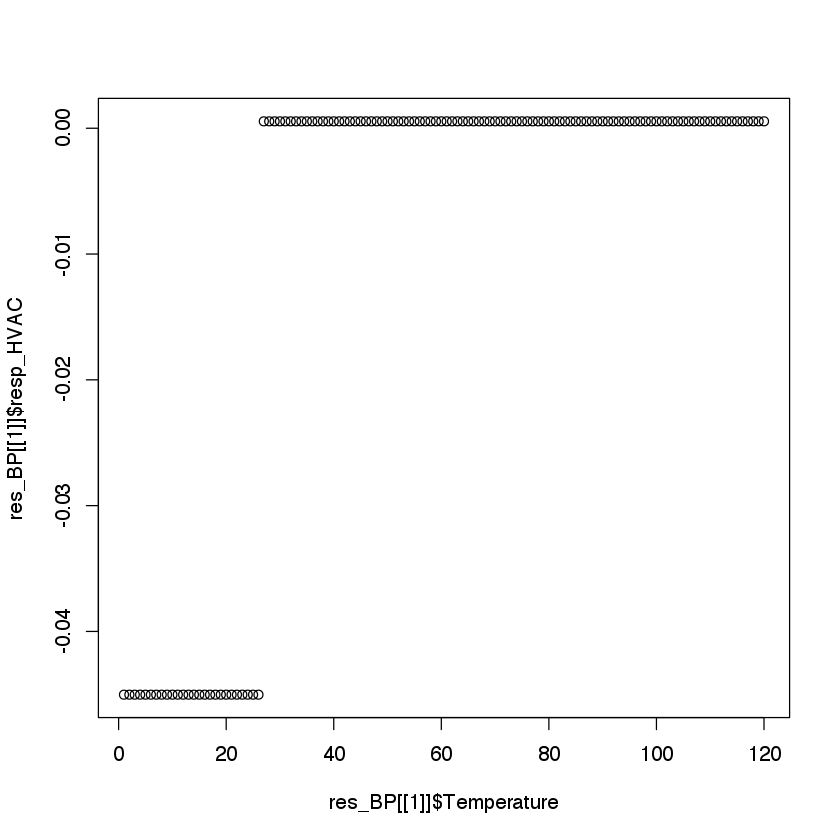

In [131]:
plot(res_BP[[1]]$Temperature, res_BP[[1]]$resp_HVAC)

##Produce visualizations

In [132]:
# use custom colors for each end use
cols = c(use= '#000000', AC = '#FE2E2E', HV = '#0040FF', user = '#088A08', nonHVAC = '#5F04B4',
     lights = '#B45F04', always_on = '#01A9DB', scheduled = '#FF00BF', TemperatureF = '#424242')


Plot ground truth response for HV/AC on same graph


In [133]:
f_plot_GT_profile = function(df_orig, df_resp){
    plot(df_orig$Temperature, df_orig$HVAC, pch ='.', cex=0, col = rgb(1, 1, 1, 0.5),
        cex.main=2, main="Ground Truth Temperature Profile", 
        cex.lab=1.5,
        cex.axis=1.2, xlab="Temperature [F]", ylab="Ground Truth HVAC (kWh)")

    if ('H' %in% names(df_orig))
        points(df_orig$Temperature, df_orig$H, pch ='.', cex=2.5, col = rgb(0, 0, 1, 0.5))
        lines(df_resp$Temperature, df_resp$fit_HV, type='l', col='blue', lwd=4, xlab="")

    if ('C' %in% names(df_orig))
        points(df_orig$Temperature, df_orig$C, pch ='.', cex=2.5, col = rgb(1, 0, 0, 0.5))
        lines(df_resp$Temperature, df_resp$fit_AC, type='l', col='red', lwd=4, xlab="")
    legend("bottomright", intersect(c("C", "H"), names(df_orig)), 
       lty=c(1,1), # gives the legend appropriate symbols (lines)
       lwd=c(2.5,2.5),col=c("red","blue"),
       cex=1.5)

    gc()
}

Plot response profiles

In [134]:
f_plot_response = function(df_resp, uname=""){
    v = c(df_resp$resp_HVAC, df_resp$resp_avg, df_resp$resp_HVAC_BP)
    if ('C' %in% names(df_resp)) v = c(v, df_resp$C)
    if ('H' %in% names(df_resp)) v = c(v, df_resp$H)
    ylim_resp = range(v)
    plot(df_resp$Temperature, df_resp$resp_HVAC, col='green', type='l', lwd=5, 
         cex.main=2, 
         cex.lab=2,
         cex.axis=2, 
         ylim=ylim_resp,
         main=paste("Ground Truth Thermal Response:", uname), 
         xlab="Temperature [F]", ylab="Response [kW/F]")
    if ('C' %in% names(df_resp))
        points(df_resp$Temperature, df_resp$AC, col='red', type='l', lwd=5)
    if ('H' %in% names(df_resp))
        points(df_resp$Temperature, df_resp$HV, col='blue', type='l', lwd=5) 
    points(df_resp$Temperature, df_resp$resp_avg, col='black', type='l', lwd=5)
    points(df_resp$Temperature, df_resp$resp_HVAC_BP, col='magenta', type='l', lwd=5)

    cols = c("green", "red","blue", "black", "magenta"); 
    names(cols) = c("HVAC (GT)", "Cool (GT)", "Heat (GT)", "HVAC (TR)", "HVAC (BP)")
    cur_labels = c("HVAC (TR)", "HVAC (BP)")
    if ("H" %in% names(df_resp)) cur_labels = c("Heat (GT)", cur_labels)
    if ("C" %in% names(df_resp)) cur_labels = c("Cool (GT)", cur_labels)
    if ("resp_HVAC" %in% names(df_resp)) cur_labels = c("HVAC (GT)", cur_labels)       
    legend("topleft", cur_labels, 
           lty=c(1,1), # gives the legend appropriate symbols (lines)
           lwd=c(2.5,2.5),col=cols[cur_labels],
           cex=1.5)
    abline(h=0, lwd = 2, col='black')
}


In [135]:
fname

ERROR: Error in eval(expr, envir, enclos): object 'fname' not found


In [136]:
user_info = paste(row$UID, row$name, sep="_")
dirname = paste(PLOT_PATH, user_info,  sep="")
dir.create(dirname, recursive = T)
fname =  paste(dirname, paste(c(user_info, row$grain, "ground_truth_response.pdf"),collapse='_'), sep="/")

df_resp_BP = res_BP[[1]]; names(df_resp_BP) = paste(names(df_resp_BP), "BP", sep="_")
df_resp_BP = cbind(df_resp, df_resp_BP, resp_avg = res$resp_profile$resp_avg[-1])
pdf(file=fname,width=7,height=5)
mar.default <- c(5,4,4,2) + 0.1
par(mar = mar.default + c(0, 1, 0, 0)) 
f_plot_response(df_resp_BP)
dev.off()

Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1105_Grant' already exists

pdf 
  2

##Process data to extract response

In [137]:
f_wrapper = function(row) {
    df_orig = read.csv(as.character(row$file_orig))
    res_HMM = f_process_model(row)                   # load & process data from HMM model
    times_ok= res_HMM$data$timestamps
    res_GTH = f_estimate_GT_resp(df_orig, times_ok)      # compute "ground truth" fit
    prof_HMM= f_estimate_empirical_prob(res_HMM$data)# estimate empirical probabil
    res_BP  = f_estimate_breakpoint_LM(df_orig)
    
    df_resp_HMM = res_HMM$resp_profile
    df_resp_GTH = res_GTH
    df_resp = cbind(df_resp_HMM[-nrow(df_resp_HMM),], df_resp_GTH[,-1])
    df_resp$grain = row$grain
    df_resp$name  = row$name
    df_resp$UID   = row$UID
    df_resp_BP    = res_BP[[1]]; names(df_resp_BP) = paste(names(df_resp_BP), "BP", sep="_")
    df_resp       = cbind(df_resp, df_resp_BP, resp_avg = res_HMM$resp_profile$resp_avg[-1])
     
    # prepare directory
    user_info = paste(row$UID, row$name, sep="_")
    dirname = paste(PLOT_PATH, user_info,  sep="")
    dir.create(dirname, recursive = T)

    # plot model regime probability profile
    fname =  paste(dirname, paste(c(user_info, row$grain, "state_prob_profile.pdf"),collapse='_'), sep="/")
    if (file.exists(fname)) file.remove(fname)
    pdf(file = fname, 7, 5)
    f_plot_prob_profiles(prof_HMM, res_HMM$resp_profile)
    dev.off()
    
    # plot ground truth estimation of response profiles
    fname =  paste(dirname, paste(c(user_info, row$grain, "ground_truth_response.pdf"),collapse='_'), sep="/")
    if (file.exists(fname)) file.remove(fname)
    pdf(file = fname, 7, 4.5)
    mar.default <- c(5,4,4,3) + 0.1
    par(mar = mar.default + c(0, 1, 0, 0)) 
    f_plot_response(df_resp, uname=row$name)
    dev.off()
    
    # plot response profiles on same axis (ground truth, HMM)
    fname =  paste(dirname, paste(c(user_info, row$grain, "all_response_profiles.pdf"),collapse='_'), sep="/")
    if (file.exists(fname)) file.remove(fname)
    pdf(file = fname, 7, 5)
    f_plot_GT_profile(df_orig, df_resp_GTH)
    dev.off()
    gc()
    return(df_resp)
}

In [138]:
row

,UID,name,grain,file_model_decode,file_model_interp,file_orig
3,1105,Grant,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//1105_Grant/60min/1105_Grant_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//1105_Grant/60min/1105_Grant_interpreted.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/1105.csv


In [139]:
head(df_resp)

,Temperature,fit_HVAC,resp_HVAC,fit_HV,resp_HV,fit_AC,resp_AC
1,1,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05
2,2,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05
3,3,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05
4,4,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05
5,5,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05
6,6,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05,0.001324195,-5.038138e-05


In [140]:
tmp =f_wrapper(row)

Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1105_Grant' already exists

In [141]:
info_files[info_files$name%in% c('Nelson', 'Jose', 'Peter'),]

,UID,name,grain,file_model_decode,file_model_interp,file_orig
41,2158,Peter,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//2158_Peter/60min/2158_Peter_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//2158_Peter/60min/2158_Peter_interpreted.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/2158.csv
200,6836,Nelson,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//6836_Nelson/60min/6836_Nelson_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//6836_Nelson/60min/6836_Nelson_interpreted.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/6836.csv
226,7800,Jose,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//7800_Jose/60min/7800_Jose_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//7800_Jose/60min/7800_Jose_interpreted.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/7800.csv


In [142]:
thermal_model = list()
for (i in 1:nrow(info_files)) {
    row <- info_files[i,]
    print(paste("Processing file", i, "of", nrow(info_files), ":", row$UID))
    thermal_model[[length(thermal_model)+1]] = f_wrapper(row)
}


[1] "Processing file 1 of 301 : 1069"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1069_Edd' already exists

[1] "Processing file 2 of 301 : 1086"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1086_Emery' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 3 of 301 : 1105"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1105_Grant' already exists

[1] "Processing file 4 of 301 : 114"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/114_James' already exists

[1] "Processing file 5 of 301 : 1167"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1167_Jerome' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 6 of 301 : 1169"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1169_George' already exists

[1] "Processing file 7 of 301 : 1185"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1185_Frank' already exists

[1] "Processing file 8 of 301 : 1283"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1283_Thomas' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 9 of 301 : 1331"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1331_Max' already exists

[1] "Processing file 10 of 301 : 1334"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1334_Henry' already exists

[1] "Processing file 11 of 301 : 135"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/135_Mose' already exists

[1] "Processing file 12 of 301 : 1392"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1392_Steve' already exists

[1] "Processing file 13 of 301 : 1450"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1450_Gordon' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 14 of 301 : 1464"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1464_Robert' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 15 of 301 : 1500"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1500_Pete' already exists

[1] "Processing file 16 of 301 : 1507"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1507_Chris' already exists

[1] "Processing file 17 of 301 : 1577"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1577_Clark' already exists

[1] "Processing file 18 of 301 : 160"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/160_Gustave' already exists

[1] "Processing file 19 of 301 : 1617"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1617_Orville' already exists

[1] "Processing file 20 of 301 : 1629"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1629_Lorenzo' already exists

[1] "Processing file 21 of 301 : 1632"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1632_Bruce' already exists

[1] "Processing file 22 of 301 : 1642"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1642_Walter' already exists

[1] "Processing file 23 of 301 : 1681"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1681_Marcus' already exists

[1] "Processing file 24 of 301 : 1696"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1696_Preston' already exists

[1] "Processing file 25 of 301 : 1697"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1697_Arthur' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 26 of 301 : 1714"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1714_Albert' already exists

[1] "Processing file 27 of 301 : 1718"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1718_Samuel' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 28 of 301 : 1790"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1790_Louis' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 29 of 301 : 1830"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1830_Donald' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 30 of 301 : 1854"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1854_Jackson' already exists

[1] "Processing file 31 of 301 : 1947"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1947_Cecil' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 32 of 301 : 1953"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1953_Daniel' already exists

[1] "Processing file 33 of 301 : 1994"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/1994_Barney' already exists

[1] "Processing file 34 of 301 : 2004"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2004_Delbert' already exists

[1] "Processing file 35 of 301 : 2018"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2018_Edmond' already exists

[1] "Processing file 36 of 301 : 2034"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2034_Anderson' already exists

[1] "Processing file 37 of 301 : 2062"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2062_Ernest' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 38 of 301 : 2094"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2094_Jesse' already exists

[1] "Processing file 39 of 301 : 2129"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2129_Oscar' already exists

[1] "Processing file 40 of 301 : 2156"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2156_Lewis' already exists

[1] "Processing file 41 of 301 : 2158"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2158_Peter' already exists

[1] "Processing file 42 of 301 : 2171"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2171_Benjamin' already exists

[1] "Processing file 43 of 301 : 2199"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2199_Frederick' already exists

[1] "Processing file 44 of 301 : 2247"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2247_Jefferson' already exists

[1] "Processing file 45 of 301 : 2360"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2360_Luke' already exists

[1] "Processing file 46 of 301 : 2365"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2365_Neal' already exists

[1] "Processing file 47 of 301 : 2378"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2378_Burt' already exists

[1] "Processing file 48 of 301 : 2470"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2470_Jacob' already exists

[1] "Processing file 49 of 301 : 2575"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2575_Elmer' already exists

[1] "Processing file 50 of 301 : 26"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/26_Carl' already exists

[1] "Processing file 51 of 301 : 2606"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2606_Tony' already exists

[1] "Processing file 52 of 301 : 2638"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2638_Lee' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 53 of 301 : 2641"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2641_Conrad' already exists

[1] "Processing file 54 of 301 : 275"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/275_Matt' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 55 of 301 : 2769"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2769_Riley' already exists

[1] "Processing file 56 of 301 : 2787"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2787_Vincent' already exists

[1] "Processing file 57 of 301 : 280"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/280_Emory' already exists

[1] "Processing file 58 of 301 : 2814"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2814_Martin' already exists

[1] "Processing file 59 of 301 : 2818"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2818_Michael' already exists

[1] "Processing file 60 of 301 : 2829"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2829_Bert' already exists

[1] "Processing file 61 of 301 : 2845"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2845_Nick' already exists

[1] "Processing file 62 of 301 : 2864"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2864_Herman' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 63 of 301 : 2945"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2945_Francis' already exists

[1] "Processing file 64 of 301 : 2953"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2953_Ezra' already exists

[1] "Processing file 65 of 301 : 2965"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2965_Harvey' already exists

[1] "Processing file 66 of 301 : 297"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/297_Green' already exists

[1] "Processing file 67 of 301 : 2995"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/2995_Juan' already exists

[1] "Processing file 68 of 301 : 3032"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3032_Clifton' already exists

[1] "Processing file 69 of 301 : 3036"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3036_Ed' already exists

[1] "Processing file 70 of 301 : 3039"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3039_Claude' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 71 of 301 : 3044"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3044_Lucius' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 72 of 301 : 3087"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3087_Porter' already exists

[1] "Processing file 73 of 301 : 3092"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3092_Arnold' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 74 of 301 : 3192"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3192_Ben' already exists

[1] "Processing file 75 of 301 : 3221"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3221_Bud' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 76 of 301 : 3263"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3263_Jeremiah' already exists

[1] "Processing file 77 of 301 : 3273"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3273_Taylor' already exists

[1] "Processing file 78 of 301 : 3367"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3367_Paul' already exists

[1] "Processing file 79 of 301 : 3392"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3392_Roland' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 80 of 301 : 3394"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3394_Spencer' already exists

[1] "Processing file 81 of 301 : 3411"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3411_Burton' already exists

[1] "Processing file 82 of 301 : 3425"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3425_Don' already exists

[1] "Processing file 83 of 301 : 3443"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3443_Emmet' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 84 of 301 : 3456"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3456_Edgar' already exists

[1] "Processing file 85 of 301 : 347"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/347_Gustav' already exists

[1] "Processing file 86 of 301 : 3482"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3482_Isaac' already exists

[1] "Processing file 87 of 301 : 3484"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3484_Louie' already exists

[1] "Processing file 88 of 301 : 3500"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3500_Otto' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 89 of 301 : 3504"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3504_Luther' already exists

[1] "Processing file 90 of 301 : 3531"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3531_Morgan' already exists

[1] "Processing file 91 of 301 : 3615"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3615_Ned' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 92 of 301 : 3649"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3649_Van' already exists

[1] "Processing file 93 of 301 : 3678"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3678_Chauncey' already exists

[1] "Processing file 94 of 301 : 370"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/370_Theodore' already exists

[1] "Processing file 95 of 301 : 3719"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3719_Hugh' already exists

[1] "Processing file 96 of 301 : 3721"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3721_Ferdinand' already exists

[1] "Processing file 97 of 301 : 3723"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3723_Clyde' already exists

[1] "Processing file 98 of 301 : 3736"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3736_General' already exists

[1] "Processing file 99 of 301 : 3778"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3778_Alexander' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 100 of 301 : 3795"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3795_Julian' already exists

[1] "Processing file 101 of 301 : 3829"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3829_Kenneth' already exists

[1] "Processing file 102 of 301 : 3864"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3864_Mitchell' already exists

[1] "Processing file 103 of 301 : 3873"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3873_Allie' already exists

[1] "Processing file 104 of 301 : 3883"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3883_Josh' already exists

[1] "Processing file 105 of 301 : 3893"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3893_Judson' already exists

[1] "Processing file 106 of 301 : 3916"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3916_Lyman' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 107 of 301 : 3935"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3935_Floyd' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 108 of 301 : 3938"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3938_Napoleon' already exists

[1] "Processing file 109 of 301 : 3967"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3967_Jack' already exists

[1] "Processing file 110 of 301 : 3973"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/3973_Pedro' already exists

[1] "Processing file 111 of 301 : 410"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/410_Horace' already exists

[1] "Processing file 112 of 301 : 4135"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4135_Marion' already exists

[1] "Processing file 113 of 301 : 4154"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4154_Philip' already exists

[1] "Processing file 114 of 301 : 4220"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4220_Berry' already exists

[1] "Processing file 115 of 301 : 4251"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4251_Archie' already exists

[1] "Processing file 116 of 301 : 4296"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4296_Dewitt' already exists

[1] "Processing file 117 of 301 : 4298"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4298_Ervin' already exists

[1] "Processing file 118 of 301 : 4313"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4313_Forest' already exists

[1] "Processing file 119 of 301 : 4321"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4321_Lynn' already exists

[1] "Processing file 120 of 301 : 4329"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4329_Pink' already exists

[1] "Processing file 121 of 301 : 434"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/434_Ruben' already exists

[1] "Processing file 122 of 301 : 4342"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4342_Sanford' already exists

[1] "Processing file 123 of 301 : 4352"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4352_Raymond' already exists

[1] "Processing file 124 of 301 : 4373"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4373_Warren' already exists

[1] "Processing file 125 of 301 : 4416"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4416_Douglas' already exists

[1] "Processing file 126 of 301 : 4495"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4495_Omer' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 127 of 301 : 4514"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4514_Ulysses' already exists

[1] "Processing file 128 of 301 : 4544"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4544_Walker' already exists

[1] "Processing file 129 of 301 : 457"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/457_Wilbert' already exists

[1] "Processing file 130 of 301 : 4641"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4641_Leo' already exists

[1] "Processing file 131 of 301 : 4660"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4660_Benjiman' already exists

[1] "Processing file 132 of 301 : 4767"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4767_Ray' already exists

[1] "Processing file 133 of 301 : 4773"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4773_Jonas' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 134 of 301 : 4776"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4776_Major' already exists

[1] "Processing file 135 of 301 : 48"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/48_Abner' already exists

[1] "Processing file 136 of 301 : 4800"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4800_Archibald' already exists

[1] "Processing file 137 of 301 : 484"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/484_Sidney' already exists

[1] "Processing file 138 of 301 : 4856"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4856_Caleb' already exists

[1] "Processing file 139 of 301 : 4864"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4864_Clint' already exists

[1] "Processing file 140 of 301 : 4874"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4874_Dudley' already exists

[1] "Processing file 141 of 301 : 490"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/490_Granville' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 142 of 301 : 4922"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4922_King' already exists

[1] "Processing file 143 of 301 : 4946"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4946_Mary' already exists

[1] "Processing file 144 of 301 : 4956"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4956_Merton' already exists

[1] "Processing file 145 of 301 : 4967"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4967_Antonio' already exists

[1] "Processing file 146 of 301 : 499"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/499_Bennie' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 147 of 301 : 4998"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/4998_Dan' already exists

[1] "Processing file 148 of 301 : 5026"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5026_Carroll' already exists

[1] "Processing file 149 of 301 : 508"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/508_Josiah' already exists

[1] "Processing file 150 of 301 : 5109"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5109_Milo' already exists

[1] "Processing file 151 of 301 : 5209"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5209_Royal' already exists

[1] "Processing file 152 of 301 : 5218"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5218_Perry' already exists

[1] "Processing file 153 of 301 : 5275"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5275_Anthony' already exists

[1] "Processing file 154 of 301 : 5356"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5356_Elza' already exists

[1] "Processing file 155 of 301 : 5357"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5357_Eddie' already exists

[1] "Processing file 156 of 301 : 5371"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5371_Amos' already exists

[1] "Processing file 157 of 301 : 5395"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5395_Dennis' already exists

[1] "Processing file 158 of 301 : 5403"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5403_Clifford' already exists

[1] "Processing file 159 of 301 : 5448"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5448_Emerson' already exists

[1] "Processing file 160 of 301 : 5449"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5449_Fletcher' already exists

[1] "Processing file 161 of 301 : 545"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/545_Alonzo' already exists

[1] "Processing file 162 of 301 : 5485"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5485_Laurence' already exists

[1] "Processing file 163 of 301 : 5539"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5539_Neil' already exists

[1] "Processing file 164 of 301 : 5545"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5545_Roger' already exists

[1] "Processing file 165 of 301 : 5552"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5552_Seth' already exists

[1] "Processing file 166 of 301 : 5568"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5568_Franklin' already exists

[1] "Processing file 167 of 301 : 5673"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5673_Glen' already exists

[1] "Processing file 168 of 301 : 5677"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5677_Hugo' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 169 of 301 : 5746"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5746_Nathan' already exists

[1] "Processing file 170 of 301 : 5785"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5785_Harold' already exists

[1] "Processing file 171 of 301 : 5786"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5786_Jimmie' already exists

[1] "Processing file 172 of 301 : 580"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/580_Johnnie' already exists

[1] "Processing file 173 of 301 : 5814"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5814_Levi' already exists

[1] "Processing file 174 of 301 : 5852"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5852_Washington' already exists

[1] "Processing file 175 of 301 : 5874"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5874_Lester' already exists

[1] "Processing file 176 of 301 : 5889"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5889_Elwood' already exists

[1] "Processing file 177 of 301 : 59"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/59_Gust' already exists

[1] "Processing file 178 of 301 : 5938"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5938_Harmon' already exists

[1] "Processing file 179 of 301 : 5949"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5949_Adam' already exists

[1] "Processing file 180 of 301 : 5959"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5959_Jordan' already exists

[1] "Processing file 181 of 301 : 5972"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5972_Lloyd' already exists

[1] "Processing file 182 of 301 : 5994"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/5994_Simeon' already exists

[1] "Processing file 183 of 301 : 6072"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6072_Mack' already exists

[1] "Processing file 184 of 301 : 6078"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6078_Wayne' already exists

[1] "Processing file 185 of 301 : 6101"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6101_Fredrick' already exists

[1] "Processing file 186 of 301 : 6121"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6121_Jay' already exists

[1] "Processing file 187 of 301 : 6139"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6139_Jess' already exists

[1] "Processing file 188 of 301 : 6165"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6165_Wilber' already exists

[1] "Processing file 189 of 301 : 6191"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6191_Clem' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 190 of 301 : 624"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/624_Melvin' already exists

[1] "Processing file 191 of 301 : 6378"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6378_Frederic' already exists

[1] "Processing file 192 of 301 : 6412"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6412_Aaron' already exists

[1] "Processing file 193 of 301 : 6500"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6500_Irwin' already exists

[1] "Processing file 194 of 301 : 6593"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6593_Lafayette' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 195 of 301 : 661"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/661_Loren' already exists

[1] "Processing file 196 of 301 : 6636"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6636_Gilbert' already exists

[1] "Processing file 197 of 301 : 6692"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6692_Madison' already exists

[1] "Processing file 198 of 301 : 6730"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6730_Gus' already exists

[1] "Processing file 199 of 301 : 6826"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6826_Mason' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 200 of 301 : 6836"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6836_Nelson' already exists

[1] "Processing file 201 of 301 : 6910"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6910_Silas' already exists

[1] "Processing file 202 of 301 : 6941"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/6941_Christopher' already exists

[1] "Processing file 203 of 301 : 7016"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7016_Percy' already exists

[1] "Processing file 204 of 301 : 7062"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7062_Aubrey' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 205 of 301 : 7319"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7319_Hans' already exists

[1] "Processing file 206 of 301 : 7361"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7361_Cornelius' already exists

[1] "Processing file 207 of 301 : 739"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/739_Felix' already exists

[1] "Processing file 208 of 301 : 7390"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7390_Karl' already exists

[1] "Processing file 209 of 301 : 7436"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7436_Wash' already exists

[1] "Processing file 210 of 301 : 7491"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7491_Wilfred' already exists

[1] "Processing file 211 of 301 : 7504"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7504_Claud' already exists

[1] "Processing file 212 of 301 : 7510"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7510_Roscoe' already exists

[1] "Processing file 213 of 301 : 7512"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7512_Allan' already exists

[1] "Processing file 214 of 301 : 7527"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7527_Alphonse' already exists

[1] "Processing file 215 of 301 : 7531"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7531_Sylvester' already exists

[1] "Processing file 216 of 301 : 7536"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7536_Earnest' already exists

[1] "Processing file 217 of 301 : 7597"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7597_Dallas' already exists

[1] "Processing file 218 of 301 : 7617"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7617_Dee' already exists

[1] "Processing file 219 of 301 : 7680"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7680_Hiram' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 220 of 301 : 7703"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7703_Jason' already exists

[1] "Processing file 221 of 301 : 772"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/772_Johnny' already exists

[1] "Processing file 222 of 301 : 7731"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7731_Otis' already exists

[1] "Processing file 223 of 301 : 774"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/774_Lawson' already exists

[1] "Processing file 224 of 301 : 7769"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7769_Mark' already exists

[1] "Processing file 225 of 301 : 7788"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7788_Lew' already exists

[1] "Processing file 226 of 301 : 7800"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7800_Jose' already exists

[1] "Processing file 227 of 301 : 7850"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7850_Wilbur' already exists

[1] "Processing file 228 of 301 : 7863"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7863_Abraham' already exists

[1] "Processing file 229 of 301 : 7866"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7866_Virgil' already exists

[1] "Processing file 230 of 301 : 7875"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7875_Micheal' already exists

[1] "Processing file 231 of 301 : 7881"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7881_Orin' already exists

[1] "Processing file 232 of 301 : 7901"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7901_Cal' already exists

[1] "Processing file 233 of 301 : 7940"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7940_Elbert' already exists

[1] "Processing file 234 of 301 : 7951"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7951_Erastus' already exists

[1] "Processing file 235 of 301 : 7984"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7984_Hardy' already exists

[1] "Processing file 236 of 301 : 7989"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/7989_Marshall' already exists

[1] "Processing file 237 of 301 : 8031"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8031_Owen' already exists

[1] "Processing file 238 of 301 : 8034"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8034_Lucien' already exists

[1] "Processing file 239 of 301 : 8046"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8046_Randolph' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 240 of 301 : 8047"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8047_Wiley' already exists

[1] "Processing file 241 of 301 : 8079"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8079_Wilmer' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 242 of 301 : 8084"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8084_Anton' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 243 of 301 : 8092"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8092_Zack' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 244 of 301 : 8121"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8121_Alvah' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 245 of 301 : 8142"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8142_Bertram' already exists

[1] "Processing file 246 of 301 : 8168"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8168_Clay' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 247 of 301 : 8197"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8197_Manuel' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 248 of 301 : 8201"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8201_Giles' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 249 of 301 : 821"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/821_Grover' already exists

[1] "Processing file 250 of 301 : 8218"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8218_Harris' already exists

[1] "Processing file 251 of 301 : 8236"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8236_Phillip' already exists

[1] "Processing file 252 of 301 : 8282"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8282_Isom' already exists

[1] "Processing file 253 of 301 : 8292"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8292_Jesus' already exists

[1] "Processing file 254 of 301 : 8342"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8342_Johnie' already exists

[1] "Processing file 255 of 301 : 8419"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8419_Emmett' already exists

[1] "Processing file 256 of 301 : 8574"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8574_Lucian' already exists

[1] "Processing file 257 of 301 : 8597"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8597_Eli' already exists

[1] "Processing file 258 of 301 : 86"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/86_Nicholas' already exists

[1] "Processing file 259 of 301 : 8645"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8645_Merritt' already exists

[1] "Processing file 260 of 301 : 871"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/871_Newton' already exists

[1] "Processing file 261 of 301 : 8736"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/8736_Otho' already exists

[1] "Processing file 262 of 301 : 878"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/878_Rolla' already exists

[1] "Processing file 263 of 301 : 898"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/898_Edmund' already exists

[1] "Processing file 264 of 301 : 900"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/900_Jeff' already exists

[1] "Processing file 265 of 301 : 9213"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/9213_Hamilton' already existsWarning message:
In brewer.pal(nStates, "Dark2"): minimal value for n is 3, returning requested palette with 3 different levels


[1] "Processing file 266 of 301 : 9233"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/9233_Harve' already exists

[1] "Processing file 267 of 301 : 9295"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/9295_Leander' already exists

[1] "Processing file 268 of 301 : 93"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/93_Lon' already exists

[1] "Processing file 269 of 301 : 9340"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/9340_Melville' already exists

[1] "Processing file 270 of 301 : 9343"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/9343_Merle' already exists

[1] "Processing file 271 of 301 : 9356"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/9356_Ora' already exists

[1] "Processing file 272 of 301 : 936"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/936_Ollie' already exists

[1] "Processing file 273 of 301 : 94"


Warning message:
In dir.create(dirname, recursive = T): '/Users/adrianalbert/S3L_server/plots/pecan-street-2/94_Russell' already exists

[1] "Processing file 274 of 301 : 9462"


ERROR: Error in resp$stderr["(Intercept)", s]: incorrect number of dimensions


In [143]:
info_files[i,]

,UID,name,grain,file_model_decode,file_model_interp,file_orig
274,9462,Murray,60min,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//9462_Murray/60min/9462_Murray_decoded.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/models_2//9462_Murray/60min/9462_Murray_interpreted.RData,/Users/adrianalbert/S3L_server/energy-data/pecan_street/usage-select//60min/9462.csv


In [144]:
save(file=paste(MODEL_PATH, "all_model_results.RData", sep=''), list = c("thermal_model"))